Importing Dependencies

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

Getting The Dataset

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../Dataset',
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


Getting An Intuition About Data

In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

In [11]:
68*32

2176

In [12]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 2 1 2 1 0 0 1 0 1 1]


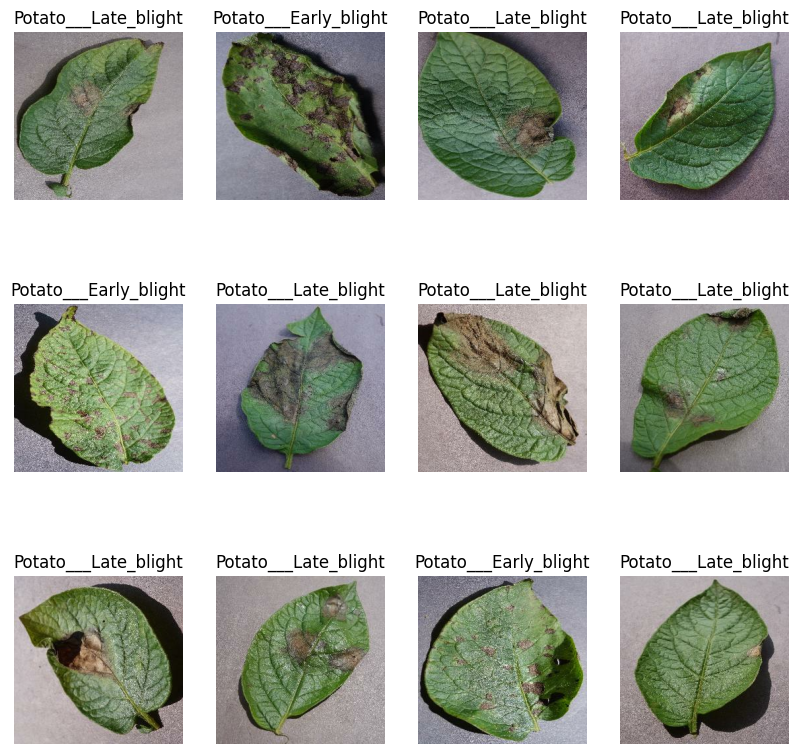

In [13]:
plt.figure(figsize = (10, 10))

for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8')) 
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

Splitting Training & Testing Data

80% ==>> Training Data

20% ==>> 10% Validation Data, 10% Testing Data

In [14]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [15]:
train_dataset_size = dataset.take(54)
len(train_dataset_size)

54

In [16]:
test_dataset_size = dataset.skip(54)
len(test_dataset_size)

14

In [17]:
val_dataset_size = 0.1
len(dataset) * val_dataset_size

6.800000000000001

In [18]:
validation_dataset_size = test_dataset_size.take(6)
len(validation_dataset_size)

6

In [19]:
test_dataset_size = test_dataset_size.skip(6)
len(test_dataset_size)

8

In [20]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

Data Preprocessing

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
        
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
        
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

C:\Users\HP\myworld\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'] 
)

In [ ]:
history = model.fit(
    train_ds, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 522ms/step - accuracy: 0.4850 - loss: 0.9411 - val_accuracy: 0.4792 - val_loss: 0.9026
Epoch 2/50
21/54 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - accuracy: 0.4873 - loss: 0.8773

In [39]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9883 - loss: 0.0362


In [40]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [42]:
history.history.keys

<function dict.keys()>

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training & validation Loss')

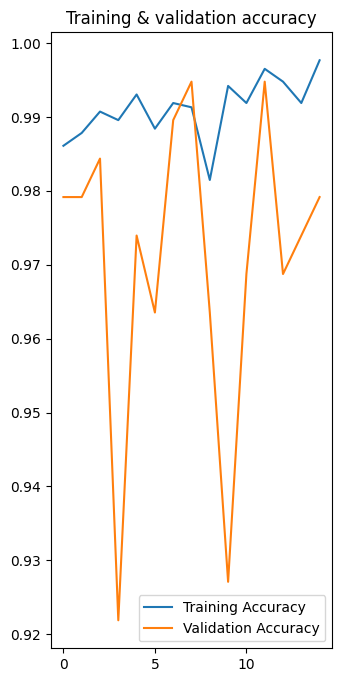

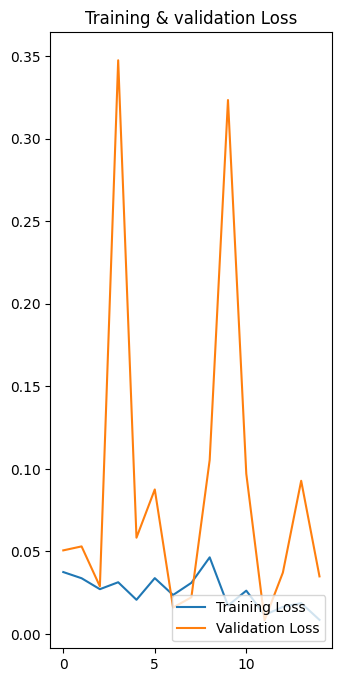

In [47]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & validation accuracy')

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training & validation Loss')